# MNIST: fully connected network



In [1]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

print (train)
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)


train_data = train.transform(train.train_data.numpy())
epsilons = [0.05, .1, .15, .2, .25, .3]

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [23]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=1)    
    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [140]:
EPOCHS = 5
losses = []

# Eval
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)

train_size = len(train_loader.dataset)
batch_size = (train_size / 256) if (cuda) else  (train_size / 64)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 5/5 [57664/60000 (96%)]	Loss: 0.009890

In [71]:
model.eval()

Model(
  (fc): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [136]:
def test( model,test_loader, epsilon ):

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = Variable(data), Variable(target)
        #print(target)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        pred = output.data.max(1)[1]
            
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        
        pert_pred = output.data.max(1)[1]
        d =pert_pred.eq(target.data).cpu()
        accuracy = d.sum().item()/d.size()[0]

       
        # Save some adv examples for visualization later
        if len(adv_im) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()   
            adv_im.append( (pred[1], pert_pred[1], adv_ex) )
    # Return the accuracy and an adversarial example
    print('\r Test Accuracy: {:.4f}%'.format(
         
            loss.cpu().item(),
            accuracy*100,
            end=''))
    
    return accuracy, adv_im


In [137]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

 Test Accuracy: 0.0976%
 Test Accuracy: 0.2377%
 Test Accuracy: 0.0844%
 Test Accuracy: 0.0039%
 Test Accuracy: 0.0017%
 Test Accuracy: 0.0016%


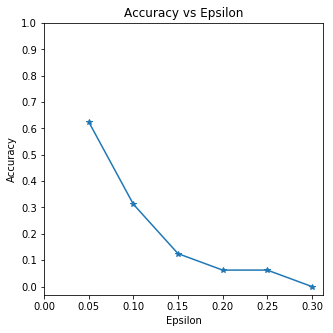

In [139]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

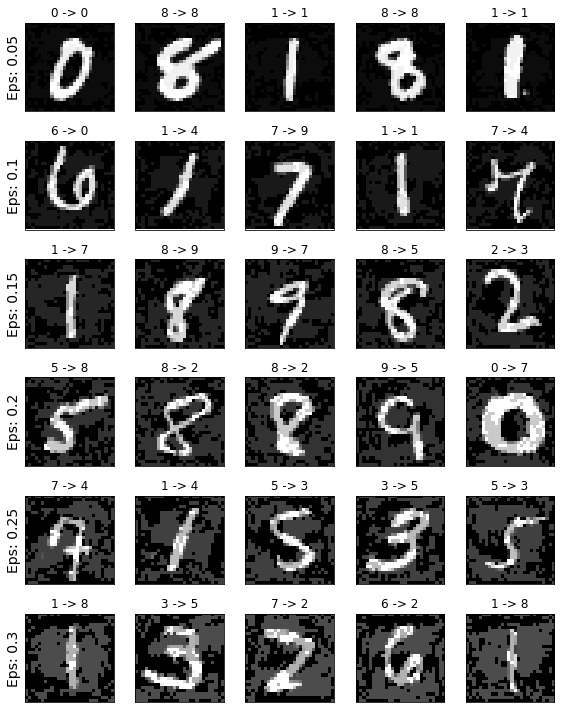

In [138]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex[1], cmap="gray")
plt.tight_layout()
plt.show()

In [66]:
model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]
print('Accuracy:', accuracy*100)

Accuracy: 98.18
